In [1]:
#!jupyter nbconvert --to script --no-prompt 1.0-load-filter-ROMS-data.ipynb

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40635,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:46665,Total threads: 4
Dashboard: /proxy/39907/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:38683,


In [4]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [5]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [6]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [7]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [8]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [9]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [10]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='1D').mean('ocean_time')])
    print('done downsampling')
    return ds_workaround

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

In [11]:
timeRange = [8005, 8205]
datelist = np.array(range(timeRange[0],timeRange[1],4))

In [12]:
# output Names
outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'

In [13]:
truth = xr.open_dataset(outputPath+outputPrefix+expNames[0]+outputSuffix)
SSHSST= xr.open_dataset(outputPath+outputPrefix+expNames[1]+outputSuffix)

In [22]:
truth

<xarray.Dataset>
Dimensions:        (s_rho: 30, s_w: 31, tracer: 2, boundary: 4, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 200)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho        (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.15 -28.16
    lon_u          (eta_rho, xi_u) float64 147.1 147.1 147.2 ... 162.1 162.2
    lat_u          (eta_rho, xi_u) float64 -38.5 -38.51 -38.52 ... -28.14 -28.15
    ...             ...
    lon_psi        (eta_v, xi_u) float64 147.1 147.2 147.2 ... 162.1 162.1 162.2
    lat_psi        (eta_v, xi_u) float64 -38.48 -38.49 -38.5 ... -28.16 -28.18
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-06-18
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0         (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/113)
    ntimes         int32 1440
    ndtfast        int32 35
    dt             float64 300.0
    dtfast         float64 8.571
    dstart         datetime64[ns] 2011-12-02
    nHIS           int32 48
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 ...
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 ...
    dA             (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [23]:
# trim variables
VarToKeep = ['temp','salt','zeta','u_eastward','v_northward','Vtransform','dA','hc','dz','dx','dy','angle','mask_rho','Cs_r','f','h']

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)

In [26]:
truth.nbytes /(1024*1024*1024)


23.2806190662086

In [15]:
print("nbytes in MB:", truth.u_eastward.nbytes/ (1024*1024))

nbytes in MB: 3947.021484375


In [16]:
print("nbytes in MB:", SSHSST.zeta.nbytes/ (1024*1024))

nbytes in MB: 131.5673828125


In [17]:
SSHSST = calc_MKEandEKEall(SSHSST)

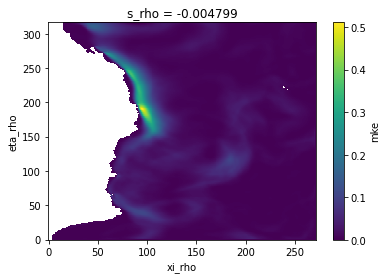

In [18]:
SSHSST.mke.isel(s_rho=-1).plot()

In [20]:
import psutil
  
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 29.7


In [19]:
STOP

NameError: name 'STOP' is not defined

In [88]:
## Load history data

filelistTruth=generateFileList(hisTruthFilePath,prefixTruth,datelist)
filelist_SSHSST=generateFileList(hisOSSEFilePath1,prefixAnalysis,datelist)
filelist_SSHSST_XBT=generateFileList(hisOSSEFilePath2,prefixAnalysis,datelist)
filelist_SSHSST_XBT_N=generateFileList(hisOSSEFilePath3,prefixAnalysis,datelist)
filelist_SSHSST_XBT_S=generateFileList(hisOSSEFilePath4,prefixAnalysis,datelist)

truth=loadOverlappedNetcdfFileList(hisTruthFilePath,prefixTruth,filelist=filelistTruth,overlapDays=7)
OSSE_SSHSST=loadOSSEFileList(hisOSSEFilePath1,prefixAnalysis, filelist=filelist_SSHSST,overlapDays=7)
OSSE_SSHSST_XBT=loadOSSEFileList(hisOSSEFilePath2,prefixAnalysis, filelist=filelist_SSHSST_XBT,overlapDays=7)
OSSE_SSHSST_XBT_N=loadOSSEFileList(hisOSSEFilePath3,prefixAnalysis, filelist=filelist_SSHSST_XBT_N,overlapDays=7)
OSSE_SSHSST_XBT_S=loadOSSEFileList(hisOSSEFilePath4,prefixAnalysis, filelist=filelist_SSHSST_XBT_S,overlapDays=7)

loaded from /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08005.nc to /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08197.nc
loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08197.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08197.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08197.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08197.nc


In [89]:
# data filtering. 8 samples == 32 hr smoothing.
smoothWindow=8

truth["u_eastward"] = truth.u_eastward.rolling(ocean_time=smoothWindow, center=True).mean()
truth["v_northward"] = truth.v_northward.rolling(ocean_time=smoothWindow, center=True).mean()
truth["temp"] = truth.temp.rolling(ocean_time=smoothWindow, center=True).mean()
truth["salt"] = truth.salt.rolling(ocean_time=smoothWindow, center=True).mean()
truth["zeta"] = truth.zeta.rolling(ocean_time=smoothWindow, center=True).mean()

OSSE_SSHSST["u_eastward"] = OSSE_SSHSST.u_eastward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST["v_northward"] = OSSE_SSHSST.v_northward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST["temp"] = OSSE_SSHSST.temp.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST["salt"] = OSSE_SSHSST.salt.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST["zeta"] = OSSE_SSHSST.zeta.rolling(ocean_time=smoothWindow, center=True).mean()

OSSE_SSHSST_XBT["u_eastward"] = OSSE_SSHSST_XBT.u_eastward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT["v_northward"] = OSSE_SSHSST_XBT.v_northward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT["temp"] = OSSE_SSHSST_XBT.temp.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT["salt"] = OSSE_SSHSST_XBT.salt.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT["zeta"] = OSSE_SSHSST_XBT.zeta.rolling(ocean_time=smoothWindow, center=True).mean()

OSSE_SSHSST_XBT_N["u_eastward"] = OSSE_SSHSST_XBT_N.u_eastward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_N["v_northward"] = OSSE_SSHSST_XBT_N.v_northward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_N["temp"] = OSSE_SSHSST_XBT_N.temp.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_N["salt"] = OSSE_SSHSST_XBT_N.salt.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_N["zeta"] = OSSE_SSHSST_XBT_N.zeta.rolling(ocean_time=smoothWindow, center=True).mean()

OSSE_SSHSST_XBT_S["u_eastward"] = OSSE_SSHSST_XBT_S.u_eastward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_S["v_northward"] = OSSE_SSHSST_XBT_S.v_northward.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_S["temp"] = OSSE_SSHSST_XBT_S.temp.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_S["salt"] = OSSE_SSHSST_XBT_S.salt.rolling(ocean_time=smoothWindow, center=True).mean()
OSSE_SSHSST_XBT_S["zeta"] = OSSE_SSHSST_XBT_S.zeta.rolling(ocean_time=smoothWindow, center=True).mean()


In [90]:
# downsample data to daily.

truth = calc_dailyDownsample(truth)
OSSE_SSHSST = calc_dailyDownsample(OSSE_SSHSST)
OSSE_SSHSST_XBT = calc_dailyDownsample(OSSE_SSHSST_XBT)
OSSE_SSHSST_XBT_N = calc_dailyDownsample(OSSE_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S = calc_dailyDownsample(OSSE_SSHSST_XBT_S)

done downsampling
done downsampling
done downsampling
done downsampling
done downsampling


In [91]:
# process into more useful format
truth = processROMSGrid(truth)
OSSE_SSHSST=processROMSGrid(OSSE_SSHSST)
OSSE_SSHSST_XBT=processROMSGrid(OSSE_SSHSST_XBT)
OSSE_SSHSST_XBT_N=processROMSGrid(OSSE_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S=processROMSGrid(OSSE_SSHSST_XBT_S)

In [83]:
# grid = makeROMSGridObject(truth)

In [16]:
# output Names
outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'

In [64]:
# now save
for var in expNames:
    print('starting saving '+var)
    ds = eval(var)
    ds.to_netcdf(path=outputPath+outputPrefix+var+outputSuffix)
    ds.close()
    print('finished saving'+var)

# truth.to_netcdf('/g/data/fu5/deg581/OSSE_analysis/data/proc/output_truth_8005_8041.nc')

starting saving truth


KeyboardInterrupt: 

In [ ]:
# all done